In [2]:
import os  # noqa: E402
import torch  # noqa: E402
import torchaudio  # noqa: E402
import matplotlib.pyplot as plt  # noqa: E402
import seaborn as sns  # noqa: E402
import pandas as pd  # noqa: E402
import random  # noqa: E402
import ast  # noqa: E402
from pathlib import Path  # noqa: E402
from concurrent.futures import ThreadPoolExecutor  # noqa: E402
import sklearn.model_selection as ms  # noqa: E402
import autoroot  # noqa: E402

from src.preprocessing import RIRutils as iru
from src.utils.unitary_linear_norm import unitary_norm

In [3]:
# random seed fix
torch.manual_seed(2036)
random.seed(2036)

In [5]:
# ------------------- prepare the noise -------------------
# DEMAND
savepath = "./data/noise_dataset"
DEMANDnoise_path = "~/Data/Datasets/DEMAND_noise"
iru.readNoise_DEMAND(DEMANDnoise_path, savepath)

In [6]:
savepath = "./data/noise_dataset"
BUT_path = "~/Data/Datasets/BUT_ReverbDB"
iru.readNoise_BUT(BUT_path, savepath, csv_savemode="a")

In [8]:
# ------------------- read the noise -------------------
noisepath_label = "./data/noise_dataset/noise.metadata/noise_label.csv"
noise_label = pd.read_csv(noisepath_label)
noisepath_data = "./data/noise_dataset/noise.data"
noise_database = []
for i in range(0, len(noise_label["filename"])):
    noise, fs = torchaudio.load(
        os.path.join(noisepath_data, noise_label["filename"][i])
    )
    noise_database.append(noise)
# shuffle the noise
random.shuffle(noise_database)

In [ ]:
# Arni RIR dataset
torch.set_default_dtype(torch.float64)
Arni_path = "~/Data/Datasets/Arni_RIR_dataset"
savepath = "./data/RIR_aggregated"
iru.readRIR_Arni(Arni_path, savepath, csv_savemode="w")

In [ ]:
# Motus RIR dataset
Motus_path = "~/Data/Datasets/Motus_RIR"
savepath = "./data/RIR_aggregated"
iru.readRIR_Motus(Motus_path, savepath, csv_savemode="a")

In [ ]:
# BUT RIR dataset
BUT_path = "~/Data/Datasets/BUT_ReverbDB"
savepath = "./data/RIR_aggregated"
iru.readRIR_BUT(BUT_path, savepath, csv_savemode="a")

In [ ]:
# ACE RIR dataset
ACE_path = "~/Data/Datasets/ACE_RIR"
savepath = "./data/RIR_aggregated"
iru.readRIR_ACE(ACE_path, savepath, csv_savemode="a")

In [ ]:
common_path = "~/Data/Datasets/OpenAIR"
root_path = "./data/RIR_aggregated"
savepath = "./data/RIR_aggregated"
iru.readRIR_OpenAIR(common_path, root_path, savepath, csv_savemode="a")

In [83]:
rir_manifest_path = "./data/RIR_aggregated/RIR.metadata/ThTtDistRcvOriSrc_label.csv"
rir_manifest = pd.read_csv(rir_manifest_path)

For first data balancing, we use equal numbers of every room to investigate the volume distribution

In [91]:
# balance the RIR dataset for equal numbers of rm ID (per 800)
import random

rir_manifest_ID_sum = pd.DataFrame(
    columns=["RIR", "roomID", "Th", "Tt", "volume", "distRcv", "oriSrc"]
)

for id in range(1, 40):
    rir_manifest_id = rir_manifest[rir_manifest["roomID"] == "rmID_" + str(id)].iloc[
        0:1
    ]
    rir_manifest_ID_sum = pd.concat(
        [rir_manifest_ID_sum, rir_manifest_id], ignore_index=True
    )

In [135]:
def volume_distri(manifest: pd.DataFrame, rm_ID_num: int):
    volume_stat = []
    for i in range(1, rm_ID_num + 1):
        volume_rmID = manifest[manifest["roomID"] == "rmID_" + str(i)].iloc[0]
        volume_stat.append(
            [
                torch.tensor(ast.literal_eval(volume_rmID["volume"]))
                .prod()
                .round(decimals=0)
                .tolist(),
                volume_rmID["roomID"],
            ]
        )
    volume_stat = pd.DataFrame(volume_stat, columns=["volume", "roomID"])

    return volume_stat.sort_values("volume", ignore_index=True)


volume_stat = volume_distri(rir_manifest_ID_sum, 39)
volume_stat

,volume,roomID
0,32.0,rmID_4
1,35.0,rmID_22
2,40.0,rmID_38
3,46.0,rmID_17
4,49.0,rmID_18
5,63.0,rmID_2
6,73.0,rmID_12
7,98.0,rmID_8
8,100.0,rmID_37
9,101.0,rmID_15


From this investigation, we determine to augment the data of which volume based on segmented levels of volume to obtain more nutural distribution.

In [122]:
def data_downsample(manifest: pd.DataFrame, N: int):
    """
    downsample the manifest
    """
    N = int(N)
    manifest_downsample = manifest.sample(n=N, random_state=2036)
    return manifest_downsample


def data_upsample(manifest: pd.DataFrame, N: int):
    """
    upsample the manifest
    """
    N = int(N)
    repeated_times = N // len(manifest)
    manifest_upsample = pd.concat([manifest] * repeated_times, ignore_index=True)
    manifest_upsample = pd.concat(
        [
            manifest_upsample,
            manifest.sample(n=N - len(manifest_upsample), random_state=2036),
        ],
        ignore_index=True,
    )
    return manifest_upsample

We processed the data augmentation to make the data better fitted for normal distribution. With regard to volume within 400, we do not do any additional data agumentation, for volume in 400 and 7000, we do additional data augmentation by 2 times. For volume in 7000 and 10000, we do additional data augmentation by 4 times.

We assume that the volume beyond 10000 is rare for daily life usage. 

By using aforementioned data augmentation strategy, we make the whole data follow the normal distribution more and more naturally.

In [257]:
rir_manifest_ID_resampled = pd.DataFrame(
    columns=["RIR", "roomID", "Th", "Tt", "volume", "distRcv", "oriSrc"]
)

N = 560 + random.randint(-20, 20)
for id in range(1, 40):
    rir_manifest_id_num = rir_manifest[rir_manifest["roomID"] == "rmID_" + str(id)]
    rir_volume = (
        rir_manifest_id_num["volume"]
        .apply(
            lambda x: torch.tensor(ast.literal_eval(x)).prod().round(decimals=0).item()
        )
        .iloc[0]
    )
    if rir_volume < 400:
        if (
            len(rir_manifest_id_num) > N
        ):  # downsample without additional data augmentation
            rir_manifest_id = data_downsample(rir_manifest_id_num, N)
            rir_manifest_ID_resampled = pd.concat(
                [rir_manifest_ID_resampled, rir_manifest_id],
                ignore_index=True,
            )
        elif (
            len(rir_manifest_id_num) < N
        ):  # upsample without additional data augmentation
            rir_manifest_id = data_upsample(rir_manifest_id_num, N)
            rir_manifest_ID_resampled = pd.concat(
                [rir_manifest_ID_resampled, rir_manifest_id],
                ignore_index=True,
            )
    elif rir_volume >= 400 and rir_volume < 7000:
        if (
            len(rir_manifest_id_num) > N * 3.5
        ):  # downsample with additional data augmentation by 2 times
            rir_manifest_id = data_downsample(rir_manifest_id_num, N * 3.5)
            rir_manifest_ID_resampled = pd.concat(
                [rir_manifest_ID_resampled, rir_manifest_id],
                ignore_index=True,
            )
        elif (
            len(rir_manifest_id_num) < N * 3.5
        ):  # upsample with additional data augmentation by 2 times
            rir_manifest_id = data_upsample(rir_manifest_id_num, N * 3.5)
            rir_manifest_ID_resampled = pd.concat(
                [rir_manifest_ID_resampled, rir_manifest_id],
                ignore_index=True,
            )
    elif rir_volume >= 7000 and rir_volume < 10000:
        if (
            len(rir_manifest_id_num) > N * 4
        ):  # downsample with additional data augmentation by 4 times
            rir_manifest_id = data_downsample(rir_manifest_id_num, N * 4)
            rir_manifest_ID_resampled = pd.concat(
                [rir_manifest_ID_resampled, rir_manifest_id],
                ignore_index=True,
            )
        elif (
            len(rir_manifest_id_num) < N * 4
        ):  # upsample with additional data augmentation by 4 times
            rir_manifest_id = data_upsample(rir_manifest_id_num, N * 4)
            rir_manifest_ID_resampled = pd.concat(
                [rir_manifest_ID_resampled, rir_manifest_id],
                ignore_index=True,
            )
    # # if needed, add more data augmentation for rarer cases
    # elif rir_volume >= 10000 and rir_volume < 20000:
    #     if (
    #         len(rir_manifest_id_num) > N * 6
    #     ):  # downsample with additional data augmentation by 4 times
    #         rir_manifest_id = data_downsample(rir_manifest_id_num, N * 6)
    #         rir_manifest_ID_resampled = pd.concat(
    #             [rir_manifest_ID_resampled, rir_manifest_id],
    #             ignore_index=True,
    #         )
    #     elif (
    #         len(rir_manifest_id_num) < N * 6
    #     ):  # upsample with additional data augmentation by 2.5 times
    #         rir_manifest_id = data_upsample(rir_manifest_id_num, N * 6)
    #         rir_manifest_ID_resampled = pd.concat(
    #             [rir_manifest_ID_resampled, rir_manifest_id],
    #             ignore_index=True,
    #         )
    # elif rir_volume >= 20000:
    #     if (
    #         len(rir_manifest_id_num) > N * 4
    #     ):  # downsample with additional data augmentation by 2.5 times
    #         rir_manifest_id = data_downsample(rir_manifest_id_num, N * 4)
    #         rir_manifest_ID_resampled = pd.concat(
    #             [rir_manifest_ID_resampled, rir_manifest_id],
    #             ignore_index=True,
    #         )
    #     elif (
    #         len(rir_manifest_id_num) < N * 4
    #     ):  # upsample with additional data augmentation by 2.5 times
    #         rir_manifest_id = data_upsample(rir_manifest_id_num, N * 4)
    #         rir_manifest_ID_resampled = pd.concat(
    #             [rir_manifest_ID_resampled, rir_manifest_id],
    #             ignore_index=True,
    #         )

In [ ]:
rir_manifest_ID_resampled.to_csv(
    "./data/RIR_aggregated/RIR.metadata/RIRLabelAugment.csv",
    index=False,
)  # save the resampled manifest

In [4]:
rir_manifest_ID_resampled = pd.read_csv(
    "./data/RIR_aggregated/RIR.metadata/RIRLabelAugmentV2.csv"
)

In [6]:
# Preprocessing of the rir dataset manifest for seaborn plotting
rir_manifest = rir_manifest_ID_resampled
# obtain RIR from which dataset
rir_manifest["RIR"] = rir_manifest["RIR"].apply(lambda x: x.split("_")[0])

Volume

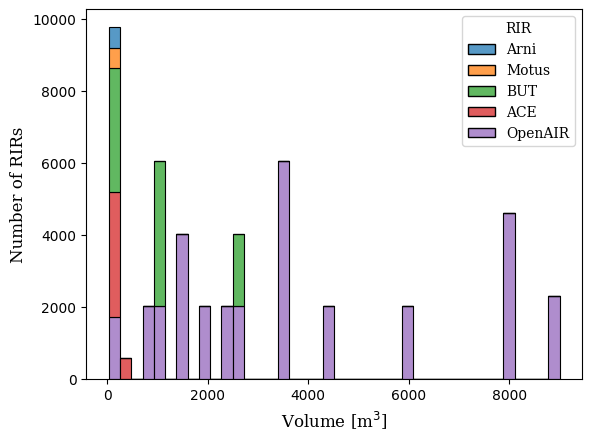

In [19]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
sns.histplot(
    x=rir_manifest["volume"].apply(
        lambda x: torch.tensor(ast.literal_eval(x)).prod().round(decimals=0).item()
    ),
    hue=rir_manifest["RIR"],
    multiple="stack",
    bins=40,
)
ax.set_xlabel("Volume [m$^3$]", fontsize=12, fontname="serif")
ax.set_ylabel("Number of RIRs", fontsize=12, fontname="serif")
fig.savefig(
    "./data/Figure/hist_volume.pdf",
    format="pdf",
)

In [7]:
volume = rir_manifest["volume"].apply(
    lambda x: torch.tensor(ast.literal_eval(x)).prod().round(decimals=0).item()
)
volume_log10 = torch.log10(torch.tensor(volume))
volume_unitary_norm = unitary_norm(volume_log10)

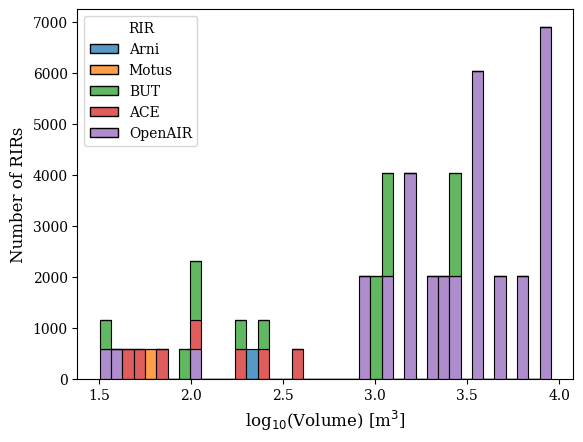

In [14]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
sns.histplot(
    x=volume_log10,
    hue=rir_manifest["RIR"],
    multiple="stack",
    bins=40,
)
ax.set_xlabel("log$_{10}$(Volume) [m$^3$]", fontname="serif", fontsize=12)
ax.set_ylabel("Number of RIRs", fontname="serif", fontsize=12)
fig.savefig(
    "./data/Figure/hist_logVolume.pdf",
    format="pdf",
)

In [8]:
print("The upper bound of the volume is: ", round(volume_log10.max().item(), 4))
print("The lower bound of the volume is: ", round(volume_log10.min().item(), 4))

The upper bound of the volume is:  3.9542
The lower bound of the volume is:  1.5051


Spatial distance of source

In [6]:
distSrc = torch.tensor(rir_manifest["distRcv"])
distSrc_norm = unitary_norm(distSrc)

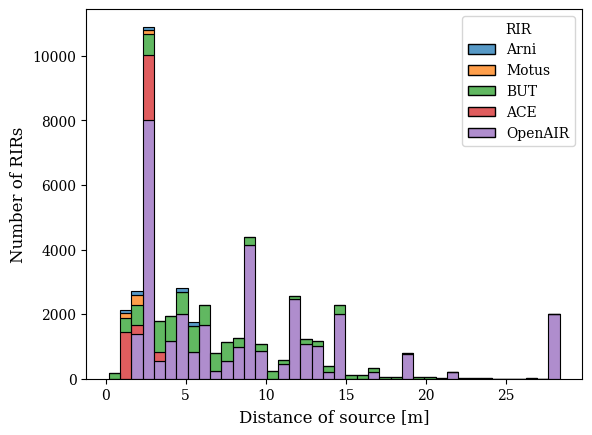

In [7]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
hist_D = sns.histplot(
    x=rir_manifest["distRcv"],
    hue=rir_manifest_ID_resampled["RIR"],
    multiple="stack",
    bins=40,
)
ax.set_xlabel("Distance of source [m]", fontname="serif", fontsize=12)
ax.set_ylabel("Number of RIRs", fontname="serif", fontsize=12)
fig.savefig(
    "./data/Figure/hist_distSrc.pdf",
    format="pdf",
)

Spatial distance of source estimation results as follows:

In [54]:
print("The upper bound of the distance is: ", round(distSrc.max().item(), 4))
print("The lower bound of the distance is: ", round(distSrc.min().item(), 4))

The upper bound of the distance is:  28.35
The lower bound of the distance is:  0.191


Ti parameter of sparse stochastic impulse response (SSIR) model

In [7]:
Th = torch.tensor(rir_manifest["Th"])
Th_unitary_norm = unitary_norm(Th).round(decimals=4).tolist()

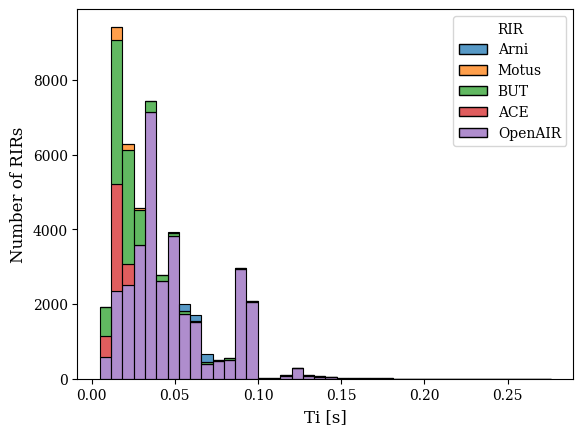

In [9]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
sns.histplot(x=rir_manifest["Th"], hue=rir_manifest["RIR"], multiple="stack", bins=40)
ax.set_xlabel("Ti [s]", fontname="serif", fontsize=12)
ax.set_ylabel("Number of RIRs", fontname="serif", fontsize=12)
fig.savefig(
    "./data/Figure/hist_Ti.pdf",
    format="pdf",
)

Ti estimation results as follows:

In [6]:
Td = torch.tensor(rir_manifest["Tt"])
print("The upper bound of Td is: ", round(Td.max().item(), 4))
print("The lower bound of Td is: ", round(Td.min().item(), 4))

The upper bound of Td is:  7.958
The lower bound of Td is:  0.188


Td parameter of sparse stochastic impulse response (SSIR) model

In [10]:
Tt = torch.tensor(rir_manifest["Tt"])
Tt_unitary_norm = unitary_norm(Tt).round(decimals=4).tolist()

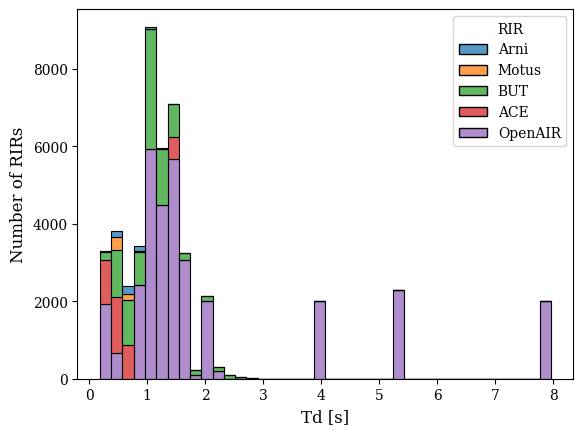

In [11]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
sns.histplot(x=rir_manifest["Tt"], hue=rir_manifest["RIR"], multiple="stack", bins=40)
ax.set_xlabel("Td [s]", fontname="serif", fontsize=12)
ax.set_ylabel("Number of RIRs", fontname="serif", fontsize=12)
fig.savefig(
    "./data/Figure/hist_Td.pdf",
    format="pdf",
)

In [8]:
print("The upper bound of Ti is: ", round(Th.max().item(), 4))
print("The lower bound of Ti is: ", round(Th.min().item(), 4))

The upper bound of Ti is:  0.276
The lower bound of Ti is:  0.005


Orientation of source (azimuth & elevation)

In [12]:
ori_src = torch.tensor(
    rir_manifest["oriSrc"].apply(lambda x: ast.literal_eval(x)).tolist()
)
azimuth_ori, elevation_ori = ori_src[:, 0], ori_src[:, 1]
azimuth_ori_unitary_norm = [
    round(elem, 5) for elem in (unitary_norm(azimuth_ori).tolist())
]
elevation_ori_unitary_norm = [
    round(elem, 5) for elem in (unitary_norm(elevation_ori).tolist())
]

In [6]:
azimuth_ori_unitary_norm_mean = torch.tensor(azimuth_ori_unitary_norm).mean()
elevation_ori_unitary_norm_mean = torch.tensor(elevation_ori_unitary_norm).mean()
print(
    "The mean of the azimuth of the source (norm) is: ",
    round(azimuth_ori_unitary_norm_mean.item(), 4),
)
print(
    "The mean of the elevation of the source (norm) is: ",
    round(elevation_ori_unitary_norm_mean.item(), 4),
)

The mean of the azimuth of the source (norm) is:  0.4986
The mean of the elevation of the source (norm) is:  0.5977


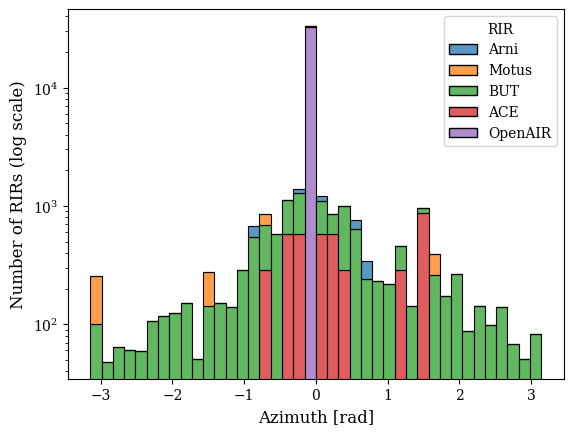

In [13]:
fig, ax = plt.subplots()
plt.rcParams["font.family"] = "serif"
sns.histplot(
    x=azimuth_ori * torch.pi,
    hue=rir_manifest["RIR"],
    multiple="stack",
    bins=40,
)
plt.yscale("log")
ax.set_xlabel("Azimuth [rad]", fontname="serif", fontsize=12)
ax.set_ylabel("Number of RIRs (log scale)", fontname="serif", fontsize=12)
fig.savefig(
    "./data/Figure/hist_azimuth.pdf",
    format="pdf",
)

Labeling for bias and unbias data of azimuth

In [86]:
azimuth_ori_unitary_norm = torch.as_tensor(azimuth_ori_unitary_norm)
azimuth_labels = (azimuth_ori_unitary_norm <= 0.4875) | (azimuth_ori_unitary_norm > 0.5)

In [89]:
azimuth_labels.unique(return_counts=True)

(tensor([False,  True]), tensor([33011, 14419]))

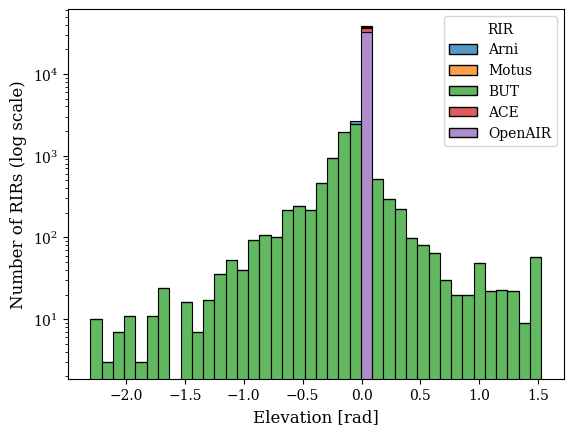

In [14]:
fig, ax = plt.subplots()
sns.histplot(
    x=elevation_ori * torch.pi, hue=rir_manifest["RIR"], multiple="stack", bins=40
)
plt.yscale("log")
ax.set_xlabel("Elevation [rad]", fontname="serif", fontsize=12)
ax.set_ylabel("Number of RIRs (log scale)", fontname="serif", fontsize=12)
fig.savefig(
    "./data/Figure/hist_elevation.pdf",
    format="pdf",
)

Labeling for bias and unbias data of elevation

In [92]:
elevation_ori_unitary_norm = torch.as_tensor(elevation_ori_unitary_norm)
elevation_labels = (elevation_ori_unitary_norm < 0.6) | (
    elevation_ori_unitary_norm > 0.605
)

In [93]:
torch.unique(elevation_labels, return_counts=True)

(tensor([False,  True]), tensor([37796,  9634]))

In [ ]:
rir_manifest_ID_resampled.insert(2, "Th_norm", Th_unitary_norm)
rir_manifest_ID_resampled.insert(3, "Tt_norm", Tt_unitary_norm)
rir_manifest_ID_resampled.insert(4, "volume_norm", volume_unitary_norm)

In [51]:
rir_manifest_ID_resampled.insert(9, "azimuth_ori_norm", azimuth_ori_unitary_norm)
rir_manifest_ID_resampled.insert(10, "elevation_ori_norm", elevation_ori_unitary_norm)

In [ ]:
rir_manifest_ID_resampled.insert(8, "distRcv_norm", distSrc_norm)

In [95]:
rir_manifest_ID_resampled

,RIR,roomID,Th_norm,Tt_norm,volume_log10_norm,Th,Tt,volume,distRcv_norm,distRcv,azimuth_ori_norm,elevation_ori_norm,oriSrc
0,Arni_RIR_no17430.wav,rmID_1,0.1845,0.0755,0.327,0.055,0.775,"[8.9, 6.3, 3.6]",0.045,1.457,0.4615,0.62100,"[-0.077, 0.024]"
1,Arni_RIR_no18160.wav,rmID_1,0.1771,0.0775,0.327,0.053,0.790,"[8.9, 6.3, 3.6]",0.045,1.457,0.4615,0.62100,"[-0.077, 0.024]"
2,Arni_RIR_no2499.wav,rmID_1,0.2030,0.0434,0.327,0.060,0.525,"[8.9, 6.3, 3.6]",0.095,2.864,0.6230,0.60213,"[0.246, 0.001]"
3,Arni_RIR_no7640.wav,rmID_1,0.1808,0.0520,0.327,0.054,0.592,"[8.9, 6.3, 3.6]",0.055,1.745,0.3590,0.61772,"[-0.282, 0.02]"
4,Arni_RIR_no12508.wav,rmID_1,0.2140,0.0709,0.327,0.063,0.739,"[8.9, 6.3, 3.6]",0.095,2.864,0.6230,0.60213,"[0.246, 0.001]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47425,OpenAIR_No177.wav,rmID_39,0.0923,0.0867,0.634,0.030,0.862,1140.0,0.419,12.000,0.4920,0.60459,"[-0.016, 0.004]"
47426,OpenAIR_No183.wav,rmID_39,0.0369,0.0921,0.634,0.015,0.904,1140.0,0.100,3.000,0.4920,0.60459,"[-0.016, 0.004]"
47427,OpenAIR_No187.wav,rmID_39,0.1402,0.0844,0.634,0.043,0.844,1140.0,0.153,4.500,0.4920,0.60459,"[-0.016, 0.004]"
47428,OpenAIR_No184.wav,rmID_39,0.0627,0.0838,0.634,0.022,0.839,1140.0,0.100,3.000,0.4920,0.60459,"[-0.016, 0.004]"


In [96]:
rir_manifest_ID_resampled.insert(13, "azimuth_classifier", azimuth_labels)
rir_manifest_ID_resampled.insert(14, "elevation_classifier", elevation_labels)

In [97]:
rir_manifest_ID_resampled

,RIR,roomID,Th_norm,Tt_norm,volume_log10_norm,Th,Tt,volume,distRcv_norm,distRcv,azimuth_ori_norm,elevation_ori_norm,oriSrc,azimuth_classifier,elevation_classifier
0,Arni_RIR_no17430.wav,rmID_1,0.1845,0.0755,0.327,0.055,0.775,"[8.9, 6.3, 3.6]",0.045,1.457,0.4615,0.62100,"[-0.077, 0.024]",True,True
1,Arni_RIR_no18160.wav,rmID_1,0.1771,0.0775,0.327,0.053,0.790,"[8.9, 6.3, 3.6]",0.045,1.457,0.4615,0.62100,"[-0.077, 0.024]",True,True
2,Arni_RIR_no2499.wav,rmID_1,0.2030,0.0434,0.327,0.060,0.525,"[8.9, 6.3, 3.6]",0.095,2.864,0.6230,0.60213,"[0.246, 0.001]",True,False
3,Arni_RIR_no7640.wav,rmID_1,0.1808,0.0520,0.327,0.054,0.592,"[8.9, 6.3, 3.6]",0.055,1.745,0.3590,0.61772,"[-0.282, 0.02]",True,True
4,Arni_RIR_no12508.wav,rmID_1,0.2140,0.0709,0.327,0.063,0.739,"[8.9, 6.3, 3.6]",0.095,2.864,0.6230,0.60213,"[0.246, 0.001]",True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47425,OpenAIR_No177.wav,rmID_39,0.0923,0.0867,0.634,0.030,0.862,1140.0,0.419,12.000,0.4920,0.60459,"[-0.016, 0.004]",False,False
47426,OpenAIR_No183.wav,rmID_39,0.0369,0.0921,0.634,0.015,0.904,1140.0,0.100,3.000,0.4920,0.60459,"[-0.016, 0.004]",False,False
47427,OpenAIR_No187.wav,rmID_39,0.1402,0.0844,0.634,0.043,0.844,1140.0,0.153,4.500,0.4920,0.60459,"[-0.016, 0.004]",False,False
47428,OpenAIR_No184.wav,rmID_39,0.0627,0.0838,0.634,0.022,0.839,1140.0,0.100,3.000,0.4920,0.60459,"[-0.016, 0.004]",False,False


In [98]:
rir_manifest_ID_resampled.to_csv(
    "~/workspace/acoustic/data/RIR_aggregated/RIR.metadata/RIRLabelAugmentV2.csv",
    index=False,
)  # save the resampled manifest

Azimuth and elevation estimation results as follows:

In [11]:
print("The upper bound of azimuth is: ", round(azimuth_ori.max().item(), 5))
print("The lower bound of azimuth is: ", round(azimuth_ori.min().item(), 5))
print("The upper bound of elevation is: ", round(elevation_ori.max().item(), 5))
print("The lower bound of elevation is: ", round(elevation_ori.min().item(), 5))

The upper bound of azimuth is:  1.0
The lower bound of azimuth is:  -1.0
The upper bound of elevation is:  0.486
The lower bound of elevation is:  -0.733


We randomly sample the speech signals from LibriSpeech dataset to match the count of the RIRs to synthsize the noisy reverberant speech signals.

In [3]:
# LibriSpeech

root_path = "./data/LibriSpeech/train-clean-360"
librispeech_folder = Path(root_path)
extension = ".flac"
matching_files = librispeech_folder.rglob(f"*{extension}")
matching_files = [str(x) for x in matching_files]


def audio_len_calc(matching_file: list):
    audio, fs = torchaudio.load(matching_file)
    length = audio.shape[-1]
    return matching_file, length


threads = []
with ThreadPoolExecutor(os.cpu_count() - 1) as executor:
    for i in range(0, len(matching_files)):
        threads.append(executor.submit(audio_len_calc, matching_files[i]))
librispeech_info = [t.result() for t in threads]
librispeech_info = pd.DataFrame(librispeech_info, columns=["filename", "length"])
librispeech_info.to_csv(
    "./data/LibriSpeech/LibriSpeech_label.csv",
    index=False,
)  # save the librispeech manifest

69602


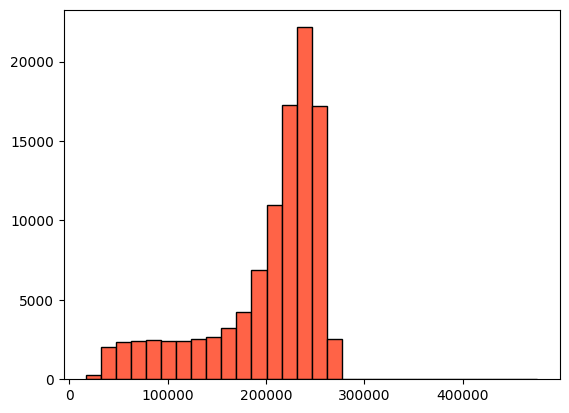

In [13]:
librispeech_info = pd.read_csv("./data/LibriSpeech/LibriSpeech_label.csv")
audio_len = librispeech_info["length"]
plt.hist(audio_len, bins=30, color="tomato", ec="black")
print(len(audio_len[(audio_len > 200528) & (audio_len < 269336)]))

After this investigation, we decide to use the sequence length between 200528 and 269336 to convolve RIR to augment data since this is the most common length of speech in LibriSpeech dataset.
For synthesized mixed speech, we select the speech below 20s 

In [12]:
def gaussian_mix_generator(rir_volume):
    if rir_volume < 400:
        n = torch.normal(mean=torch.arange(0.0, 4.0)).round().abs().int()
        n = n + 1
        n_i = torch.randint(0, 4, (1,)).item()
        n = n[n_i].tolist()
    elif rir_volume >= 400 and rir_volume < 2000:
        n = torch.normal(mean=torch.arange(2.0, 8.0)).round().abs().int()
        n = n + 1
        n_i = torch.randint(0, 6, (1,)).item()
        n = n[n_i].tolist()
    elif rir_volume >= 2000 and rir_volume < 4000:
        n = torch.normal(mean=torch.arange(3.0, 12.0)).round().abs().int()
        n = n + 1
        n_i = torch.randint(0, 9, (1,)).item()
        n = n[n_i].tolist()
    elif rir_volume >= 4000:
        n = torch.normal(mean=torch.arange(3.0, 14.0)).floor().abs().int()
        n = n + 1
        n_i = torch.randint(0, 11, (1,)).item()
        n = n[n_i].tolist()
    if n > 12:
        n = 6
    return n, rir_volume


rir_volume = rir_manifest_ID_resampled["volume"].apply(
    lambda x: torch.tensor(ast.literal_eval(x)).prod().round(decimals=0).item()
)
with ThreadPoolExecutor(max_workers=os.cpu_count() - 1) as executor:
    threads = []
    for i in range(len(rir_manifest_ID_resampled)):
        threads.append(executor.submit(gaussian_mix_generator, rir_volume.iloc[i]))
num_occ = [t.result() for t in threads]
num_occ = pd.DataFrame(num_occ, columns=["num_occ", "rir_volume"])
num_occ.to_csv(
    "./data/RIR_aggregated/RIR.metadata/num_occ.csv",
    index=False,
)

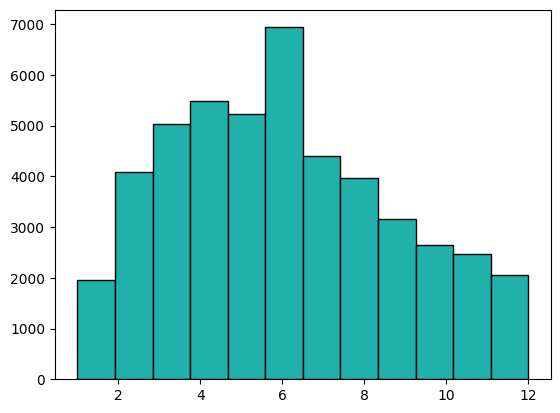

In [4]:
num_occ = pd.read_csv("./data/RIR_aggregated/RIR.metadata/num_occ.csv")

(n, bins, patches) = plt.hist(
    num_occ["num_occ"], bins=12, color="lightseagreen", ec="black"
)

In [53]:
# Dataset preparation For RIR estimation
def audio_len_calc(matching_files: list):
    audio, fs = torchaudio.load(matching_files)
    length = audio.shape[-1]
    if length > 200528 and length < 269336:
        return matching_files, length


with ThreadPoolExecutor(max_workers=os.cpu_count() - 1) as executor:
    threads = []
    for file in matching_files:
        threads.append(executor.submit(audio_len_calc, file))
audio_info = [t.result() for t in threads]

audio_info = [x for x in audio_info if x is not None]
audio_long_manifest = pd.DataFrame(audio_info, columns=["filename", "audioLength"])
audio_long_manifest.to_csv("./data/LibriSpeech/audio_long_manifest.csv", index=False)

In [5]:
rir_manifest_ID_resampled = pd.read_csv(
    "./data/Database/RIR_aggregated/RIR.metadata/RIRLabelAugmentV2.csv"
)
rir_manifest_ID_resampled

,RIR,roomID,Th_norm,Tt_norm,volume_log10_norm,Th,Tt,volume,distRcv,oriSrc
0,Arni_RIR_no17430.wav,rmID_1,0.1845,0.0755,0.327,0.055,0.775,"[8.9, 6.3, 3.6]",1.457,"[-0.077, 0.024]"
1,Arni_RIR_no18160.wav,rmID_1,0.1771,0.0775,0.327,0.053,0.790,"[8.9, 6.3, 3.6]",1.457,"[-0.077, 0.024]"
2,Arni_RIR_no2499.wav,rmID_1,0.2030,0.0434,0.327,0.060,0.525,"[8.9, 6.3, 3.6]",2.864,"[0.246, 0.001]"
3,Arni_RIR_no7640.wav,rmID_1,0.1808,0.0520,0.327,0.054,0.592,"[8.9, 6.3, 3.6]",1.745,"[-0.282, 0.02]"
4,Arni_RIR_no12508.wav,rmID_1,0.2140,0.0709,0.327,0.063,0.739,"[8.9, 6.3, 3.6]",2.864,"[0.246, 0.001]"
...,...,...,...,...,...,...,...,...,...,...
47425,OpenAIR_No177.wav,rmID_39,0.0923,0.0867,0.634,0.030,0.862,1140.0,12.000,"[-0.016, 0.004]"
47426,OpenAIR_No183.wav,rmID_39,0.0369,0.0921,0.634,0.015,0.904,1140.0,3.000,"[-0.016, 0.004]"
47427,OpenAIR_No187.wav,rmID_39,0.1402,0.0844,0.634,0.043,0.844,1140.0,4.500,"[-0.016, 0.004]"
47428,OpenAIR_No184.wav,rmID_39,0.0627,0.0838,0.634,0.022,0.839,1140.0,3.000,"[-0.016, 0.004]"


In [27]:
librispeech_info = pd.read_csv("./data/LibriSpeech/LibriSpeech_label.csv")
librispeech_info

,filename,length
0,/home/s2320016/workspace/acoustic/data/LibriSp...,58960
1,/home/s2320016/workspace/acoustic/data/LibriSp...,260080
2,/home/s2320016/workspace/acoustic/data/LibriSp...,266960
3,/home/s2320016/workspace/acoustic/data/LibriSp...,81520
4,/home/s2320016/workspace/acoustic/data/LibriSp...,250240
...,...,...
104009,/home/s2320016/workspace/acoustic/data/LibriSp...,168160
104010,/home/s2320016/workspace/acoustic/data/LibriSp...,114560
104011,/home/s2320016/workspace/acoustic/data/LibriSp...,121120
104012,/home/s2320016/workspace/acoustic/data/LibriSp...,211280


In [3]:
# Illustration of the mixed speech and its frame-level label

reverb_mixed_speech_manifest = pd.read_csv(
    "./data/mixed_speech/reverb_mixed_speech_manifest.csv"
)
mixed_speech, fs = torchaudio.load(
    os.path.join(
        os.getcwd(),
        "data/mixed_speech/mixed_speech.data/reverb_mixed",
        reverb_mixed_speech_manifest["mixed_speech"][2011],
    )
)
mixed_speech_label = torch.load(
    os.path.join(
        os.getcwd(),
        "data/mixed_speech/mixed_speech_label.data",
        reverb_mixed_speech_manifest["mixed_speech_label"][2011],
    )
)

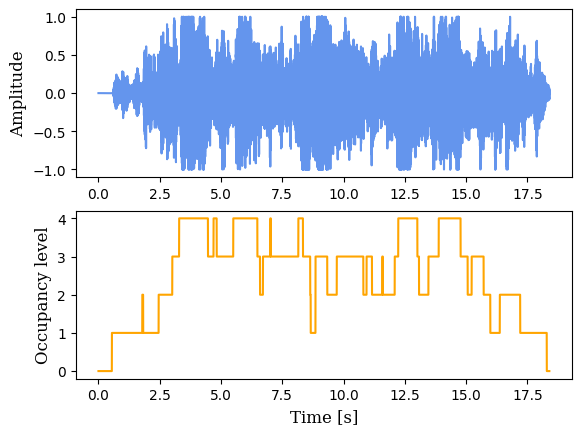

In [4]:
# Illustration of the mixed speech and its frame-level label
t = torch.arange(0, mixed_speech.shape[-1]) / fs
plt.subplot(2, 1, 1)
plt.plot(t, mixed_speech.reshape(-1), color="cornflowerblue")
plt.ylabel("Amplitude", fontsize=12, fontname="serif")
plt.subplot(2, 1, 2)
plt.plot(t, mixed_speech_label.reshape(-1), color="orange")
plt.xlabel("Time [s]", fontsize=12, fontname="serif")
plt.ylabel("Occupancy level", fontsize=12, fontname="serif")
plt.savefig(
    "./data/Figure/mixed_speech_illustration.pdf",
    format="pdf",
)

In [ ]:
# mixed speech synthesis
from scripts import synthesize_speech

synthesize_speech()

In [ ]:
# reverb speech synthesis
from scripts import synthesize_rir_speech

synthesize_rir_speech()

In [21]:
mixed_speech_downsampled_label_path = (
    "./data/mixed_speech/mixed_speech_downsampled_label.data"
)

mixed_speech_downsampled_label_lst = os.listdir(mixed_speech_downsampled_label_path)
mixed_speech_downsampled_label_lst.sort()

In [22]:
test_label = random.sample(mixed_speech_downsampled_label_lst, 4000)
test_one_sample = torch.load(
    os.path.join(mixed_speech_downsampled_label_path, test_label[2000])
).float()
test_one_sample.numel()

39

In [23]:
mixed_speech_num_occ = torch.tensor([])
for i in range(0, len(mixed_speech_downsampled_label_lst)):
    mixed_speech_num = torch.load(
        os.path.join(
            mixed_speech_downsampled_label_path, mixed_speech_downsampled_label_lst[i]
        )
    ).float()
    mixed_speech_num_occ = torch.cat([mixed_speech_num_occ, mixed_speech_num], dim=1)

Text(0, 0.5, 'Number of crowded speech signals')

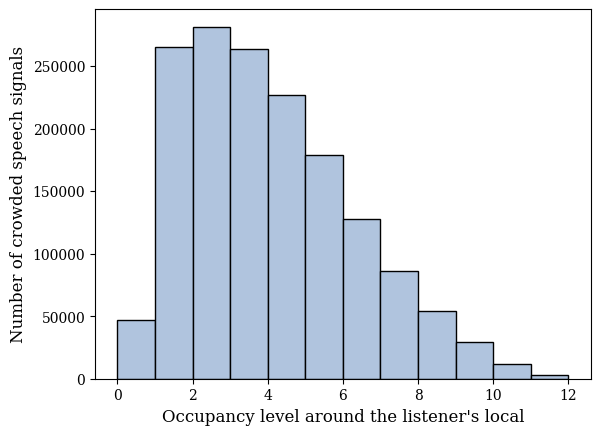

In [25]:
fig, ax = plt.subplots()
ax.hist(mixed_speech_num_occ, bins=12, color="lightsteelblue", ec="black")
ax.set_xlabel(
    "Occupancy level around the listener's local", fontname="serif", fontsize=12
)
ax.set_ylabel("Number of crowded speech signals", fontname="serif", fontsize=12)
fig.savefig(
    "./data/Figure/hist_numOcc.pdf",
    format="pdf",
)

Number of occupancy estimation results as follows:

Additional manifest preparation for the training, validation and test sets

In [106]:
# Add azimuth and elevation to the reverberant speech manifest
noisy_clean_manifest_path = "./data/noiseReverbSpeech"

noisyCleanPair = pd.read_csv(
    os.path.join(noisy_clean_manifest_path, "reverbSpeech.metadata.csv")
)

In [57]:
noisyCleanPair.insert(10, "azimuth_ori_norm", azimuth_ori_unitary_norm)
noisyCleanPair.insert(11, "elevation_ori_norm", elevation_ori_unitary_norm)

In [114]:
noisyCleanPair

,reverbSpeech,cleanSpeech,Th_unitary,Tt_unitary,volume_log10_unitary,Th,Tt,volume,volume_log10,distRcv_norm,distRcv,azimuth_ori_norm,elevation_ori_norm,oriSrc,snr_dB
0,reverbSpeech_No0.wav,clean_No0.wav,0.1845,0.0755,0.327,0.055,0.775,202.0,2.305,0.045,1.457,0.4615,0.62100,"[-0.077, 0.024]",15
1,reverbSpeech_No1.wav,clean_No1.wav,0.1771,0.0775,0.327,0.053,0.790,202.0,2.305,0.045,1.457,0.4615,0.62100,"[-0.077, 0.024]",15
2,reverbSpeech_No2.wav,clean_No2.wav,0.2030,0.0434,0.327,0.060,0.525,202.0,2.305,0.095,2.864,0.6230,0.60213,"[0.246, 0.001]",10
3,reverbSpeech_No3.wav,clean_No3.wav,0.1808,0.0520,0.327,0.054,0.592,202.0,2.305,0.055,1.745,0.3590,0.61772,"[-0.282, 0.02]",0
4,reverbSpeech_No4.wav,clean_No4.wav,0.2140,0.0709,0.327,0.063,0.739,202.0,2.305,0.095,2.864,0.6230,0.60213,"[0.246, 0.001]",20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47425,reverbSpeech_No47425.wav,clean_No47425.wav,0.0923,0.0867,0.634,0.030,0.862,1140.0,3.057,0.419,12.000,0.4920,0.60459,"[-0.016, 0.004]",10
47426,reverbSpeech_No47426.wav,clean_No47426.wav,0.0369,0.0921,0.634,0.015,0.904,1140.0,3.057,0.100,3.000,0.4920,0.60459,"[-0.016, 0.004]",20
47427,reverbSpeech_No47427.wav,clean_No47427.wav,0.1402,0.0844,0.634,0.043,0.844,1140.0,3.057,0.153,4.500,0.4920,0.60459,"[-0.016, 0.004]",5
47428,reverbSpeech_No47428.wav,clean_No47428.wav,0.0627,0.0838,0.634,0.022,0.839,1140.0,3.057,0.100,3.000,0.4920,0.60459,"[-0.016, 0.004]",0


In [116]:
noisyCleanPair.insert(15, "azimuth_classifier", azimuth_labels)
noisyCleanPair.insert(16, "elevation_classifier", elevation_labels)

In [117]:
noisyCleanPair

,reverbSpeech,cleanSpeech,Th_unitary,Tt_unitary,volume_log10_unitary,Th,Tt,volume,volume_log10,distRcv_norm,distRcv,azimuth_ori_norm,elevation_ori_norm,oriSrc,snr_dB,azimuth_classifier,elevation_classifier
0,reverbSpeech_No0.wav,clean_No0.wav,0.1845,0.0755,0.327,0.055,0.775,202.0,2.305,0.045,1.457,0.4615,0.62100,"[-0.077, 0.024]",15,True,True
1,reverbSpeech_No1.wav,clean_No1.wav,0.1771,0.0775,0.327,0.053,0.790,202.0,2.305,0.045,1.457,0.4615,0.62100,"[-0.077, 0.024]",15,True,True
2,reverbSpeech_No2.wav,clean_No2.wav,0.2030,0.0434,0.327,0.060,0.525,202.0,2.305,0.095,2.864,0.6230,0.60213,"[0.246, 0.001]",10,True,False
3,reverbSpeech_No3.wav,clean_No3.wav,0.1808,0.0520,0.327,0.054,0.592,202.0,2.305,0.055,1.745,0.3590,0.61772,"[-0.282, 0.02]",0,True,True
4,reverbSpeech_No4.wav,clean_No4.wav,0.2140,0.0709,0.327,0.063,0.739,202.0,2.305,0.095,2.864,0.6230,0.60213,"[0.246, 0.001]",20,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47425,reverbSpeech_No47425.wav,clean_No47425.wav,0.0923,0.0867,0.634,0.030,0.862,1140.0,3.057,0.419,12.000,0.4920,0.60459,"[-0.016, 0.004]",10,False,False
47426,reverbSpeech_No47426.wav,clean_No47426.wav,0.0369,0.0921,0.634,0.015,0.904,1140.0,3.057,0.100,3.000,0.4920,0.60459,"[-0.016, 0.004]",20,False,False
47427,reverbSpeech_No47427.wav,clean_No47427.wav,0.1402,0.0844,0.634,0.043,0.844,1140.0,3.057,0.153,4.500,0.4920,0.60459,"[-0.016, 0.004]",5,False,False
47428,reverbSpeech_No47428.wav,clean_No47428.wav,0.0627,0.0838,0.634,0.022,0.839,1140.0,3.057,0.100,3.000,0.4920,0.60459,"[-0.016, 0.004]",0,False,False


In [118]:
noisyCleanPair.to_csv(
    os.path.join(noisy_clean_manifest_path, "reverbSpeech.metadata.csv"), index=False
)

------------------ Split train， val， and test ---------------------

In [119]:
noisy_clean_manifest_path = "./data/noiseReverbSpeech"

val_size = test_size = 2000

noisyCleanPair = pd.read_csv(
    os.path.join(noisy_clean_manifest_path, "reverbSpeech.metadata.csv")
)

train_manifest, test_manifest = ms.train_test_split(
    noisyCleanPair,
    train_size=len(noisyCleanPair) - test_size,
    test_size=test_size,
    random_state=2036,
)

train_manifest, val_manifest = ms.train_test_split(
    train_manifest,
    train_size=len(train_manifest) - val_size,
    test_size=val_size,
    random_state=2036,
)


# shuffle
train_manifest = train_manifest.sample(frac=1, random_state=2036).reset_index(drop=True)
val_manifest = val_manifest.sample(frac=1, random_state=2036).reset_index(drop=True)
test_manifest = test_manifest.sample(frac=1, random_state=2036).reset_index(drop=True)

manifest_path = "./data/noiseReverbSpeech"
if not os.path.exists(manifest_path):
    os.makedirs(manifest_path)
train_manifest.to_csv(os.path.join(manifest_path, "train_manifest.csv"), index=False)
val_manifest.to_csv(os.path.join(manifest_path, "val_manifest.csv"), index=False)
test_manifest.to_csv(os.path.join(manifest_path, "test_manifest.csv"), index=False)

In [70]:
train_manifest = pd.read_csv("./data/noiseReverbSpeech/train_manifest.csv")

0        reverbSpeech_No40032.wav
1        reverbSpeech_No34362.wav
2        reverbSpeech_No17016.wav
3        reverbSpeech_No11807.wav
4        reverbSpeech_No43137.wav
                   ...           
43425    reverbSpeech_No32905.wav
43426    reverbSpeech_No31691.wav
43427    reverbSpeech_No43077.wav
43428     reverbSpeech_No8795.wav
43429    reverbSpeech_No15862.wav
Name: reverbSpeech, Length: 43430, dtype: object

In [61]:
# add the azimuth and elevation to the reverb speech manifest
train_manifest_reverb = pd.read_csv("./data/noiseReverbSpeech/train_manifest.csv")
val_manifest_reverb = pd.read_csv("./data/noiseReverbSpeech/val_manifest.csv")
test_manifest_reverb = pd.read_csv("./data/noiseReverbSpeech/test_manifest.csv")

In [11]:
mixed_speech_manifest_path = "./data/Database/mixed_speech"

mixed_clean_manifest = pd.read_csv(
    os.path.join(mixed_speech_manifest_path, "mixed_speech_manifest.csv")
)

mixed_reverb_manifest = pd.read_csv(
    os.path.join(mixed_speech_manifest_path, "reverb_mixed_speech_manifest.csv")
)

# add numOcc info to mixed_clean_manifest
num_occ = mixed_reverb_manifest["numOcc"]
mixed_clean_manifest.insert(2, "numOcc", num_occ)
# remove rir_info from mixed_clean_manifest
mixed_reverb_manifest = mixed_reverb_manifest.drop(columns=["rir_info"])

mixed_clean_manifest.to_csv(
    os.path.join(mixed_speech_manifest_path, "mixed_speech_manifest.csv"), index=False
)
mixed_reverb_manifest.to_csv(
    os.path.join(mixed_speech_manifest_path, "reverb_mixed_speech_manifest.csv"),
    index=False,
)

In [ ]:
val_size = test_size = 2000

(
    train_mixed_clean_manifest,
    test_mixed_clean_manifest,
    train_mixed_reverb_manifest,
    test_mixed_reverb_manifest,
) = ms.train_test_split(
    mixed_clean_manifest, mixed_reverb_manifest, test_size=test_size, random_state=2036
)

(
    train_mixed_clean_manifest,
    val_mixed_clean_manifest,
    train_mixed_reverb_manifest,
    val_mixed_reverb_manifest,
) = ms.train_test_split(
    train_mixed_clean_manifest,
    train_mixed_reverb_manifest,
    test_size=val_size,
    random_state=2036,
)

# shuffle and save
train_mixed_clean_manifest.sample(frac=1, random_state=2036).reset_index(
    drop=True
).to_csv(
    os.path.join(mixed_speech_manifest_path, "train_mixed_clean_manifest.csv"),
    index=False,
)

val_mixed_clean_manifest.sample(frac=1, random_state=2036).reset_index(
    drop=True
).to_csv(
    os.path.join(mixed_speech_manifest_path, "val_mixed_clean_manifest.csv"),
    index=False,
)

test_mixed_clean_manifest.sample(frac=1, random_state=2036).reset_index(
    drop=True
).to_csv(
    os.path.join(mixed_speech_manifest_path, "test_mixed_clean_manifest.csv"),
    index=False,
)


train_mixed_reverb_manifest.sample(frac=1, random_state=2036).reset_index(
    drop=True
).to_csv(
    os.path.join(mixed_speech_manifest_path, "train_mixed_reverb_manifest.csv"),
    index=False,
)


val_mixed_reverb_manifest.sample(frac=1, random_state=2036).reset_index(
    drop=True
).to_csv(
    os.path.join(mixed_speech_manifest_path, "val_mixed_reverb_manifest.csv"),
    index=False,
)


test_mixed_reverb_manifest.sample(frac=1, random_state=2036).reset_index(
    drop=True
).to_csv(
    os.path.join(mixed_speech_manifest_path, "test_mixed_reverb_manifest.csv"),
    index=False,
)

----------- Split train, val and test dataset for mixed_speech

In [11]:
mixed_speech_manifest_path = "./data/mixed_speech"

val_size = test_size = 2000

reverb_mixed_speech_manifest = pd.read_csv(
    os.path.join(mixed_speech_manifest_path, "mixed_speech_manifest.csv")
)

train_manifest, test_manifest = ms.train_test_split(
    reverb_mixed_speech_manifest,
    train_size=len(reverb_mixed_speech_manifest) - test_size,
    test_size=test_size,
    random_state=2036,
)

train_manifest, val_manifest = ms.train_test_split(
    train_manifest,
    train_size=len(train_manifest) - val_size,
    test_size=val_size,
    random_state=2036,
)


# shuffle
train_manifest = train_manifest.sample(frac=1, random_state=2036).reset_index(drop=True)
val_manifest = val_manifest.sample(frac=1, random_state=2036).reset_index(drop=True)
test_manifest = test_manifest.sample(frac=1, random_state=2036).reset_index(drop=True)

manifest_path = "./data/mixed_speech"
if not os.path.exists(manifest_path):
    os.makedirs(manifest_path)
train_manifest.to_csv(os.path.join(manifest_path, "train_manifest.csv"), index=False)
val_manifest.to_csv(os.path.join(manifest_path, "val_manifest.csv"), index=False)
test_manifest.to_csv(os.path.join(manifest_path, "test_manifest.csv"), index=False)